# 하이브리드 추천방식 활용
1. KMeans로 군집화
2. 군집 내에서 가장 유사한 10명의 유저 추출 (Cosine 유사도)

## 0.라이브러리

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import cosine_similarity

## 1. 데이터 로드 & 전처리 컬럼 설정

In [84]:
df = pd.read_csv('../data/VL_CSV/tn_traveller_master_여행객 Master_E.csv')

In [85]:
df.drop('JOB_ETC', axis=1, inplace=True)

In [86]:
df.head().T

,0,1,2,3,4
TRAVELER_ID,e004720,e000914,e003564,e000396,e001890
RESIDENCE_SGG_CD,41,30,41,41,11
GENDER,여,여,여,여,남
AGE_GRP,60,20,30,30,20
EDU_NM,4,6,7,6,6
EDU_FNSH_SE,1.0,1.0,1.0,1.0,1.0
MARR_STTS,3,1,2,2,1
FAMILY_MEMB,3,1,4,2,4
JOB_NM,11,3,2,2,3
INCOME,4,4,7,2,5


In [87]:
# 사용할 컬럼 정의
categorical_cols = [
    'GENDER', 'EDU_NM', 'EDU_FNSH_SE', 'MARR_STTS', 'JOB_NM',
    'INCOME', 'HOUSE_INCOME', 'TRAVEL_TERM',
    'TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3', 'TRAVEL_STYL_4',
    'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_7', 'TRAVEL_STYL_8',
    'TRAVEL_MOTIVE_1', 'TRAVEL_MOTIVE_2'
]

numerical_cols = [
    'AGE_GRP', 'FAMILY_MEMB', 'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM',
    'TRAVEL_LIKE_SIDO_1', 'TRAVEL_LIKE_SIDO_2', 'TRAVEL_LIKE_SIDO_3'
]

use_cols = categorical_cols + numerical_cols

# 전처리용 데이터 필터링 (결측치 제거)
df_filtered = df[use_cols].dropna()

In [88]:
df_filtered.shape, df.shape

((1919, 25), (2560, 35))

## 2. 전처리 및 군집화 파이프라인 작성

In [89]:
# 전처리 파이프라인
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# 클러스터링 포함 파이프라인 (8개 클러스터 기준)
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('cluster', KMeans(n_clusters=8, random_state=42))
])

# 학습
pipeline.fit(df_filtered)

# 클러스터 결과 저장
df_filtered['cluster'] = pipeline.named_steps['cluster'].labels_

## 3. 군집 내 유사 유저 추출

In [90]:
# 원본 데이터에서 전처리 후 유저 ID 등 다시 붙이기 위해 인덱스 저장
df_with_id = df.copy()
df_filtered = df[use_cols].dropna()
df_filtered['cluster'] = pipeline.named_steps['cluster'].labels_

# cluster index를 활용해 원본 데이터 반환
def recommend_similar_users_in_cluster(user_data: dict, top_n: int = 10):
    input_df = pd.DataFrame([user_data])[use_cols]
    input_vec = pipeline.named_steps['preprocess'].transform(input_df)
    
    # 클러스터 예측
    predicted_cluster = pipeline.named_steps['cluster'].predict(input_vec)[0]

    # 해당 클러스터 내 유저 추출 (index 기준)
    cluster_indices = df_filtered[df_filtered['cluster'] == predicted_cluster].index
    cluster_users = df_with_id.loc[cluster_indices] 

    # 전처리 벡터로 유사도 계산
    cluster_vecs = pipeline.named_steps['preprocess'].transform(df_filtered.loc[cluster_indices][use_cols])
    sim_scores = cosine_similarity(input_vec, cluster_vecs)[0]
    top_indices = np.argsort(sim_scores)[::-1][:top_n]

    return cluster_users.iloc[top_indices].copy()


## 4. 테스트

In [91]:
example_user = {
    'GENDER': '여',
    'EDU_NM': 4,
    'EDU_FNSH_SE': 1,
    'MARR_STTS': 3,
    'JOB_NM': 11,
    'INCOME': 4,
    'HOUSE_INCOME': 9,
    'TRAVEL_TERM': 2,
    'TRAVEL_LIKE_SIDO_1': 11,
    'TRAVEL_LIKE_SIDO_2': 47,
    'TRAVEL_LIKE_SIDO_3': 41,
    'TRAVEL_STYL_1': 2,
    'TRAVEL_STYL_2': 4,
    'TRAVEL_STYL_3': 4,
    'TRAVEL_STYL_4': 4,
    'TRAVEL_STYL_5': 4,
    'TRAVEL_STYL_6': 4,
    'TRAVEL_STYL_7': 5,
    'TRAVEL_STYL_8': 5,
    'TRAVEL_MOTIVE_1': 2,
    'TRAVEL_MOTIVE_2': 6,
    'AGE_GRP': 20,
    'FAMILY_MEMB': 3,
    'TRAVEL_NUM': 2,
    'TRAVEL_COMPANIONS_NUM': 1
}

top_users = recommend_similar_users_in_cluster(example_user, top_n=10)

# 확인
print(top_users[['TRAVELER_ID', 'AGE_GRP', 'TRAVEL_STATUS_DESTINATION']])


     TRAVELER_ID  AGE_GRP TRAVEL_STATUS_DESTINATION
74       e004655       30                        서울
2444     e008489       30                        경기
2481     e006028       20                        서울
851      e012070       20                        서울
972      e002402       30                        서울
1370     e002536       20                        서울
1771     e004338       30                        서울
241      e010222       20                        서울
729      e007753       40                        경기
156      e002784       20                        서울


- 유사도 높은 유저의 ID가 나오므로, 방문했던 여행지를 찾아낼 수 있음

In [92]:
travel = pd.read_csv('../data/VL_CSV/tn_travel_여행_E.csv')
area = pd.read_csv('../data/VL_CSV/tn_visit_area_info_방문지정보_E.csv')

In [93]:
travel = travel[travel['TRAVELER_ID'].isin(top_users['TRAVELER_ID'])]
len(travel)

10

In [94]:
travel_ids = travel['TRAVEL_ID'].to_list()
filter_area = ['집', '사무실', '학교', '기타']
area = area[(area['TRAVEL_ID'].isin(travel_ids)) & (~area['VISIT_AREA_NM'].isin(filter_area))]
len(area)

61

In [95]:
area['VISIT_AREA_NM'][:20]

6235               진명스포아트
6236    브루클린 더 버거 조인트 이촌점
6237              국립중앙박물관
6549              친구 친지 집
6550                  오송역
6551                 아이시티
6552           인왕산 수성동 계곡
6553              인왕산 둘레길
6554            더 숲 초소 책방
6555            인왕산 숲속 쉼터
6556             청운 문학도서관
6557         코비 브라이트 광화문점
6558                  덕수궁
6559                 아이시티
6560             오토 김밥 본점
6561                  소월길
6562               컴포트 서울
6563              경복궁 경회루
6564                  서울역
6565                 조치원역
Name: VISIT_AREA_NM, dtype: object

**추천 시스템에서 아래의 정보는 제거해야됨**

- 방문지 정보 데이터의 이름을 모두 전처리해야 될 것
    - 역, 주유소, 휴게소 - **주유소와 역은 이동수단과 관련된 정보임**
    - 숙소 정보 - **숙소 추천은 나중에 따로**

**TODO : 각 지역에 맞는 사진 불러오는 것 알고리즘 개발 필요**

## 5. 군집 시각화

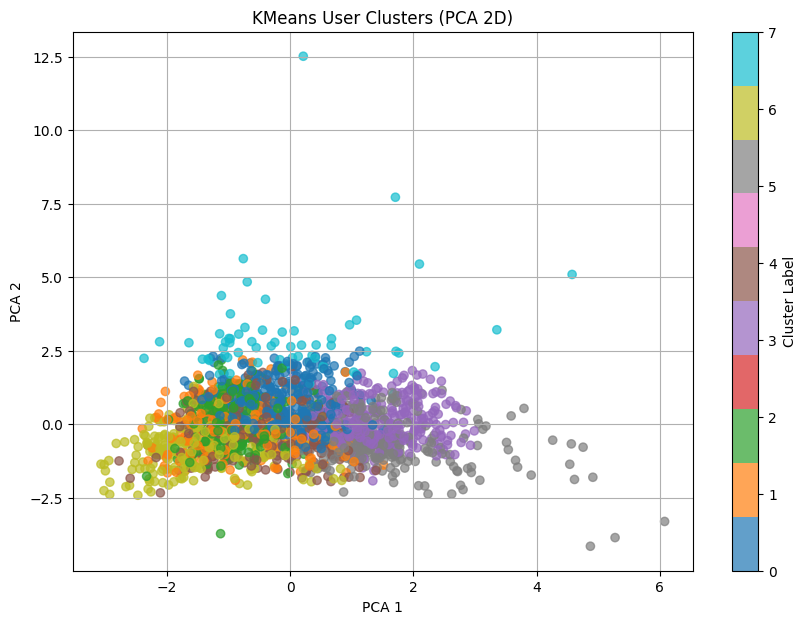

In [96]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_all = pipeline.named_steps['preprocess'].transform(df_filtered[use_cols])
cluster_labels = df_filtered['cluster'].values

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_all)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)

plt.title("KMeans User Clusters (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster Label")
plt.grid(True)
plt.show()

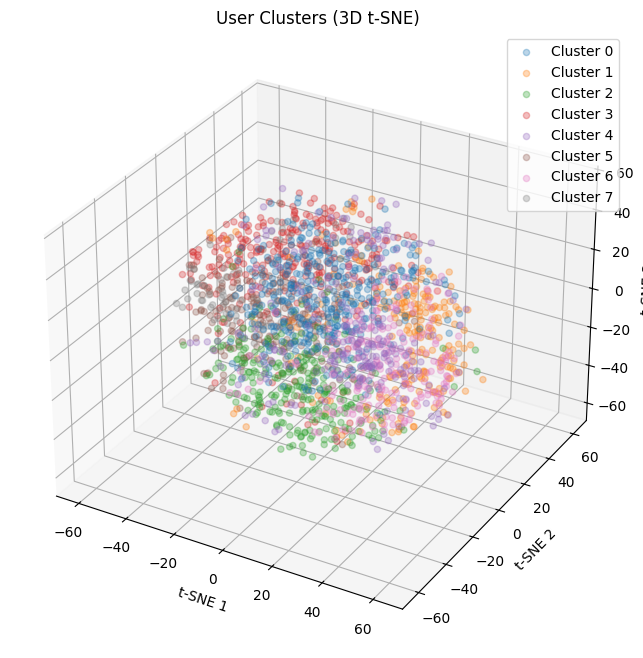

In [97]:
import seaborn as sns
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=42)
colors = sns.color_palette('tab10', len(np.unique(cluster_labels)))
X_tsne = tsne.fit_transform(X_all)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(np.unique(cluster_labels)):
    cluster_points = X_tsne[cluster_labels == label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
               c=[colors[i]], label=f'Cluster {label}', alpha=0.3)

ax.set_title("User Clusters (3D t-SNE)")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.legend()
plt.show()
